In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pywt
import tensorflow as tf

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

2024-07-21 15:28:04.919778: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-21 15:28:05.140117: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-21 15:28:05.140164: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-21 15:28:05.184586: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-21 15:28:05.269130: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-21 15:28:05.270778: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
tf.__version__

'2.15.0'

## Data Loading

In [3]:
df = pd.read_csv("../data/lcms-sidaguri_duha.csv")
# df = pd.read_csv("../data/lcms-kejibeling_sirih.csv")
df.head()

,RT,Aa1.raw,Aa2.raw,Aa3.raw,Aa4.raw,Aa5.raw,Ab1.raw,Ab2.raw,Ab3.raw,Ab4.raw,...,DuhaJateng1.raw (F3),DuhaJateng2.raw (F4),DuhaJateng3.raw (F5),DuhaJateng4.raw (F6),DuhaJateng5.raw (F7),DuhaJatim1.raw (F8),DuhaJatim2.raw (F9),DuhaJatim3.raw (F10),DuhaJatim4.raw (F11),DuhaJatim5.raw (F12)
0,0.019797,7579428.0,6852407.0,7101667.5,60449512,2924847.5,6136222.5,7799085.0,6042445.5,6537382.0,...,3.017131e+06,3.401932e+07,2.328197e+06,2.772848e+06,3.218821e+06,2.514035e+06,4.573899e+06,4.393425e+06,4.457953e+06,4.583001e+06
1,0.055817,18549750.0,16219179.0,16545254.0,86253528,12099423.0,15689369.0,16050252.0,13947545.0,12688849.0,...,1.071946e+07,7.178993e+06,1.047283e+07,8.114961e+06,9.222108e+06,5.124252e+06,5.636934e+06,5.341372e+06,6.969250e+06,4.814211e+06
2,0.090755,33037904.0,30960996.0,32147658.0,136940290,38096916.0,35367760.0,31386694.0,29200438.0,30544476.0,...,5.594114e+07,1.655864e+07,4.120143e+07,3.910545e+07,3.998068e+07,6.369658e+07,6.756587e+07,1.059816e+08,9.060372e+07,7.099268e+07
3,0.126510,36772908.0,33426850.0,38749116.0,147312530,37148052.0,32445172.0,39901896.0,33328682.0,31328042.0,...,3.290235e+07,1.165101e+07,2.151683e+07,1.947403e+07,1.816166e+07,5.859764e+07,5.384706e+07,6.801192e+07,6.891335e+07,5.602360e+07
4,0.162102,35582084.0,33160712.0,33959024.0,162787950,36016120.0,37681864.0,29078240.0,29230690.0,33246358.0,...,3.830239e+07,2.073814e+07,3.383636e+07,2.757426e+07,2.455820e+07,4.652499e+07,4.086083e+07,5.271000e+07,5.874309e+07,4.180185e+07


<Axes: >

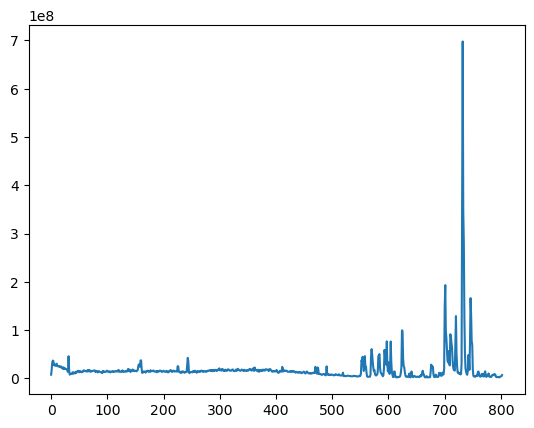

In [4]:
df["Aa1.raw"].plot()

## Preprocessing

In [5]:
# transpose columns (samples) and rows (retention time)
df_proc = df.copy().T.reset_index()

# derive new target column from the second character of each samples
df_proc["target"] = df_proc["index"].str.strip().str[1]

# remove the first row and column (retention time)
df_proc = df_proc.iloc[1:, 1:]

df_proc.head()

,0,1,2,3,4,5,6,7,8,9,...,794,795,796,797,798,799,800,801,802,target
1,7579428.0,18549750.0,33037904.0,36772908.0,35582084.0,27437276.0,28940318.0,25850548.0,28062826.0,27111998.0,...,2495263.2,2960036.8,2646452.2,1751977.8,3198442.0,3509528.8,3935330.2,4456536.5,6759127.5,a
2,6852407.0,16219179.0,30960996.0,33426850.0,33160712.0,29181614.0,29269456.0,24977570.0,26031720.0,24732540.0,...,3239194.8,8802423.0,33782976.0,75186560.0,90396040.0,31686098.0,32161922.0,40100232.0,16774360.0,a
3,7101667.5,16545254.0,32147658.0,38749116.0,33959024.0,26536074.0,28381920.0,25741172.0,25873646.0,22924234.0,...,16602223.0,35512352.0,60606952.0,57518660.0,51256524.0,33868672.0,13636603.0,10074553.0,18248406.0,a
4,60449512.0,86253528.0,136940290.0,147312530.0,162787950.0,158408830.0,127157660.0,136969620.0,121743240.0,124293530.0,...,186803120.0,183612720.0,111098420.0,98033600.0,81034328.0,71015960.0,68696328.0,93216624.0,120723370.0,a
5,2924847.5,12099423.0,38096916.0,37148052.0,36016120.0,34695196.0,30342064.0,31978138.0,31760006.0,25537286.0,...,92970032.0,42771412.0,35302048.0,13724793.0,10497660.0,15471251.0,24516046.0,18282912.0,14373862.0,a


In [6]:
# split X, y
X = df_proc.drop("target", axis=1).values
y = df_proc["target"].values

X.shape, y.shape

((165, 803), (165,))

In [7]:
# to scale data
data_mean = np.mean(X)
data_std = np.std(X)

print("Mean:", data_mean)
print("Std:", data_std)

# norm
X = (X - data_mean) / data_std

# encode target
encoder = OneHotEncoder(sparse_output=False)
y = encoder.fit_transform(y.reshape(-1, 1))

encoder.categories_

Mean: 30488685.23260185
Std: 78338321.0455869


[array(['a', 'b', 'c', 'i', 'u'], dtype=object)]

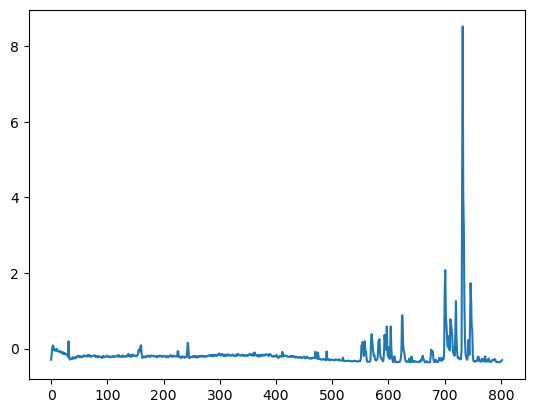

In [8]:
plt.plot(X[0])

In [9]:
# empty array for CWT results
X_cwt = np.ndarray(shape=(X.shape[0], 127, 127, 1))

# cwt for each sample
for i in range(X.shape[0]):
  cA, cD = pywt.cwt(X[i], range(1, 128), 'morl', 1)
  X_cwt[i, :, :, 0] = cA[:, :127]

In [10]:
X_cwt.shape, y.shape

((165, 127, 127, 1), (165, 5))

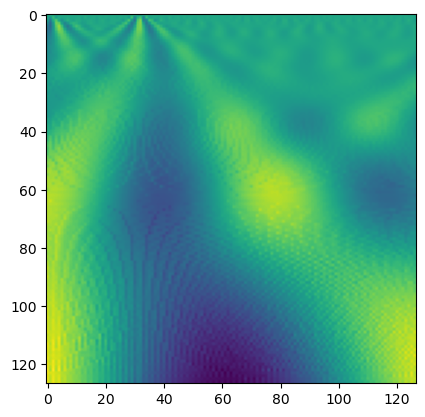

In [11]:
plt.imshow(X_cwt[0])

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_cwt, y, test_size=0.33, random_state=42, stratify=y)

## Training

In [13]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(8, kernel_size=(3, 3), padding='same', input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3],)),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPool2D(strides=(2, 2)),

    tf.keras.layers.Conv2D(16, kernel_size=(3, 3), padding='same'),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2D(16, kernel_size=(3, 3), padding='same'),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPool2D(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dense(5),
    tf.keras.layers.Softmax(),
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.F1Score(name="f1"),
        tf.keras.metrics.AUC(name="auc"),
        tf.keras.metrics.AUC(name="prc", curve="PR"),
    ]
)

model.summary()

2024-07-21 15:28:16.152579: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-21 15:28:16.153168: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 127, 127, 8)       80        
                                                                 
 re_lu (ReLU)                (None, 127, 127, 8)       0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 8)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 63, 63, 16)        1168      
                                                                 
 re_lu_1 (ReLU)              (None, 63, 63, 16)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 63, 63, 16)        2320      
                                                        

In [14]:
earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history = model.fit(X_train, y_train, epochs=30, batch_size=8, validation_data=(X_test, y_test), callbacks=[earlystopping_callback])

Epoch 1/30
14/14 [==============================] - 2s 70ms/step - loss: 1.8362 - accuracy: 0.3727 - precision: 0.7391 - recall: 0.1545 - f1: 0.4120 - auc: 0.7391 - prc: 0.4661 - val_loss: 0.9760 - val_accuracy: 0.6545 - val_precision: 1.0000 - val_recall: 0.2000 - val_f1: 0.7379 - val_auc: 0.9243 - val_prc: 0.7924
Epoch 2/30
14/14 [==============================] - 1s 38ms/step - loss: 0.8598 - accuracy: 0.6091 - precision: 0.7925 - recall: 0.3818 - f1: 0.7099 - auc: 0.9178 - prc: 0.7397 - val_loss: 0.6767 - val_accuracy: 0.6909 - val_precision: 0.6909 - val_recall: 0.6909 - val_f1: 0.7740 - val_auc: 0.9323 - val_prc: 0.7679
Epoch 3/30
14/14 [==============================] - 1s 37ms/step - loss: 0.6334 - accuracy: 0.6818 - precision: 0.7303 - recall: 0.5909 - f1: 0.7629 - auc: 0.9422 - prc: 0.8150 - val_loss: 0.5705 - val_accuracy: 0.6545 - val_precision: 0.7500 - val_recall: 0.5455 - val_f1: 0.7404 - val_auc: 0.9524 - val_prc: 0.8311
Epoch 4/30
14/14 [==============================]

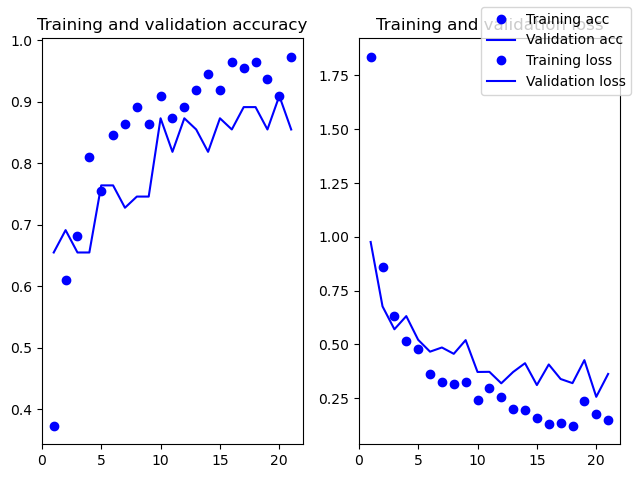

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(epochs, acc, 'bo', label='Training acc')
ax1.plot(epochs, val_acc, 'b', label='Validation acc')
ax1.set_title('Training and validation accuracy')

ax2.plot(epochs, loss, 'bo', label='Training loss')
ax2.plot(epochs, val_loss, 'b', label='Validation loss')
ax2.set_title('Training and validation loss')

fig.legend()
fig.tight_layout()
plt.show()

In [16]:
y_pred = np.argmax(model.predict(X_test), axis=1)
print(classification_report(np.argmax(y_test, axis=1), y_pred))

2/2 [==============================] - 0s 11ms/step
              precision    recall  f1-score   support

           0       0.78      0.93      0.85        15
           1       0.79      0.73      0.76        15
           2       0.92      0.80      0.86        15
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5

    accuracy                           0.85        55
   macro avg       0.90      0.89      0.89        55
weighted avg       0.86      0.85      0.85        55



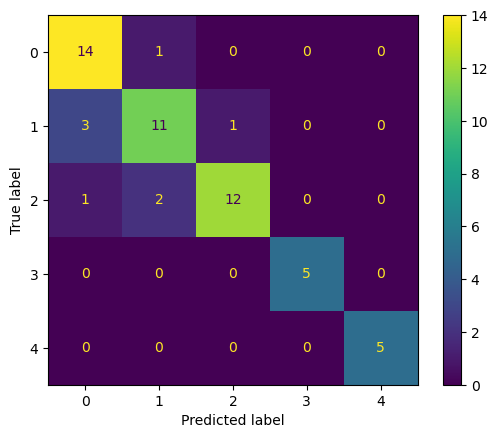

In [17]:
ConfusionMatrixDisplay.from_predictions(np.argmax(y_test, axis=1), y_pred)

In [75]:
model.save("../model/lcms_classif_kejibeling_sirih", save_format="tf")

INFO:tensorflow:Assets written to: ../model/lcms_classif_kejibeling_sirih/assets


INFO:tensorflow:Assets written to: ../model/lcms_classif_kejibeling_sirih/assets


## Grad-CAM

In [108]:
img_array = np.expand_dims(X_test[11], axis=0)
img_array.shape

(1, 127, 127, 1)

In [111]:
def draw_gradcam(img_array):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer("conv2d_2").output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
plt.imshow(draw_gradcam(img_array))

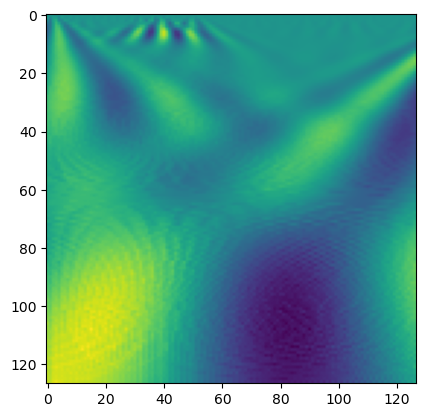

In [100]:
plt.imshow(img_array.reshape(127, 127))

In [117]:
for i in range(y_test.shape[0]):
    target = np.argmax(y_test[i])
    img_input = np.expand_dims(X_test[i], axis=0)

    heatmap_numpy = draw_gradcam(img_input)
    fig = plt.figure()
    plt.imshow(heatmap_numpy)
    fig.savefig(f"../grads/{target}_{i}.png")
    plt.close("all")